## Advanced Lane Finding Project

### The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
# import packages

from io import BytesIO
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from multiprocessing import Pool
import dill as pickle
from functools import partial

%matplotlib inline   

In [2]:
# define an output image function, used for visualization

def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    #vmax = 255 if arr.dtype == 'uint8' else 1.0
    vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

In [3]:
# read in the provided chessboards. output image points and object points

def camera_chessboards(glob_regex='camera_cal/calibration*.jpg'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    chessboards = [] # array of chessboard images
    
    # Make a list of calibration images
    images = glob.glob(glob_regex)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            chessboards.append(img)
        
    return objpoints, imgpoints, chessboards

In [4]:
# perform the chessboard function. get object points and image points
objpoints, imgpoints, chessboards = camera_chessboards()

In [5]:
# interactively navigate all chessboard images
def browse_chessboards(chessboards):
    n = len(chessboards)
    def view_image(i):
        plt.imshow(chessboards[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Chessboard: %d' % i)
        plt.show()
    interact(view_image, i=(0,n-1))

In [10]:
# output the visualization all chessbard images with corners drawn
from matplotlib import gridspec
def browse_chessboards(chessboards):
    n = len(chessboards)
    fig = plt.figure(figsize=(15,11))
    gs = gridspec.GridSpec(5, 4, wspace=0, hspace=0)
    for i in range(n):
        ax = plt.subplot(gs[i])
        plt.imshow(chessboards[i])
#     fig.savefig('output_images/chessboardcorners.png')

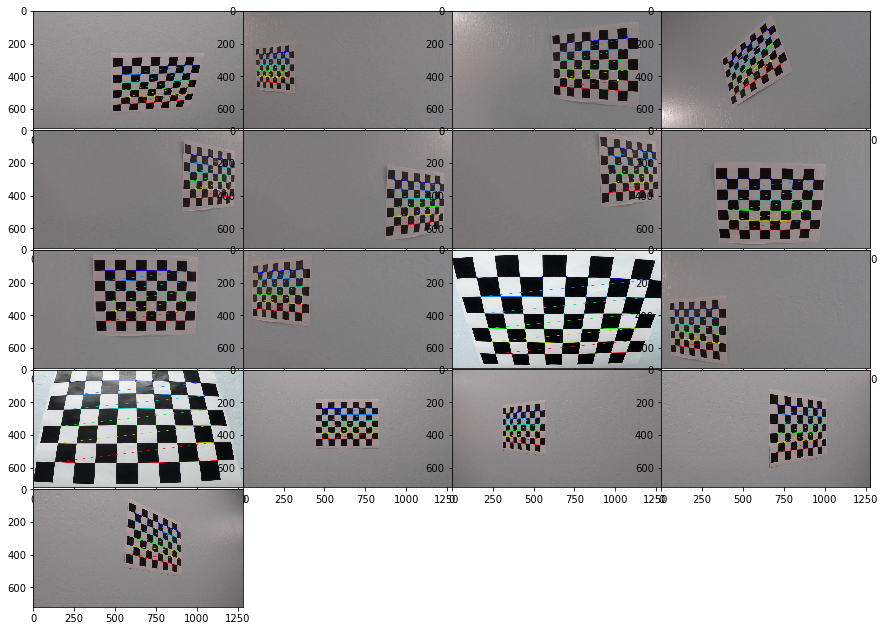

In [9]:
# output the visualization all chessbard images with corners drawn
browse_chessboards(chessboards)

In [11]:
# calibriate camera using objpoints and imgpoints. output transision matrix
def camera_calibrate(objpoints, imgpoint, img):
#     img_size = img.shape[0:2]
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return ret, mtx, dist, dst

In [16]:
# visualize all distorted chessboards 

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


def browse_chessboard_distortion(mtx, dist,glob_regex='camera_cal/calibration*.jpg'):
    images = glob.glob(glob_regex)
    chessboards = []
    for fname in images:
        img = cv2.imread(fname)
        chessboards.append(img)
    gs = gridspec.GridSpec(10, 4, wspace=0, hspace=0)
    n = len(chessboards)
    fig = plt.figure(figsize=(15,22))
    for i in range(n):
        ax = plt.subplot(gs[2*int(i/4),np.mod(i,4)])
        plt.imshow(chessboards[i])
        dst = cv2.undistort(chessboards[i], mtx, dist, None, mtx)
        ax = plt.subplot(gs[2*int(i/4)+1,np.mod(i,4)])
        plt.imshow(dst)
        
#     fig.savefig('output_images/distortedchessboards.png')
    

(1280, 720)


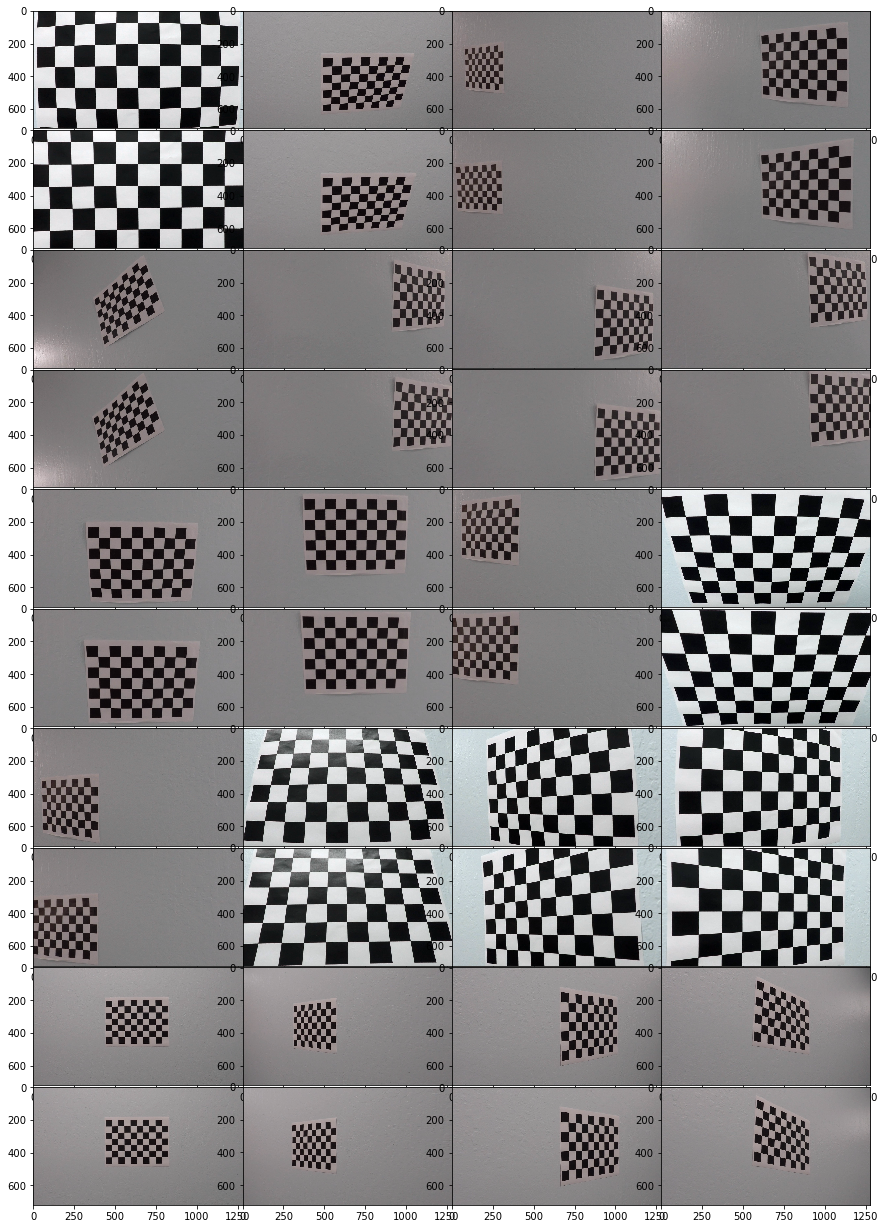

In [15]:
#visualize all distorted chessboards 
browse_chessboard_distortion(mtx, dist)

In [17]:
# define image distortion function
def undistort_image(img, mtx=mtx, dist=dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [18]:
# define image loading functions

def load_test_images(glob_regex='test_images/test*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images

def load_test_video(file_name='project_video.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

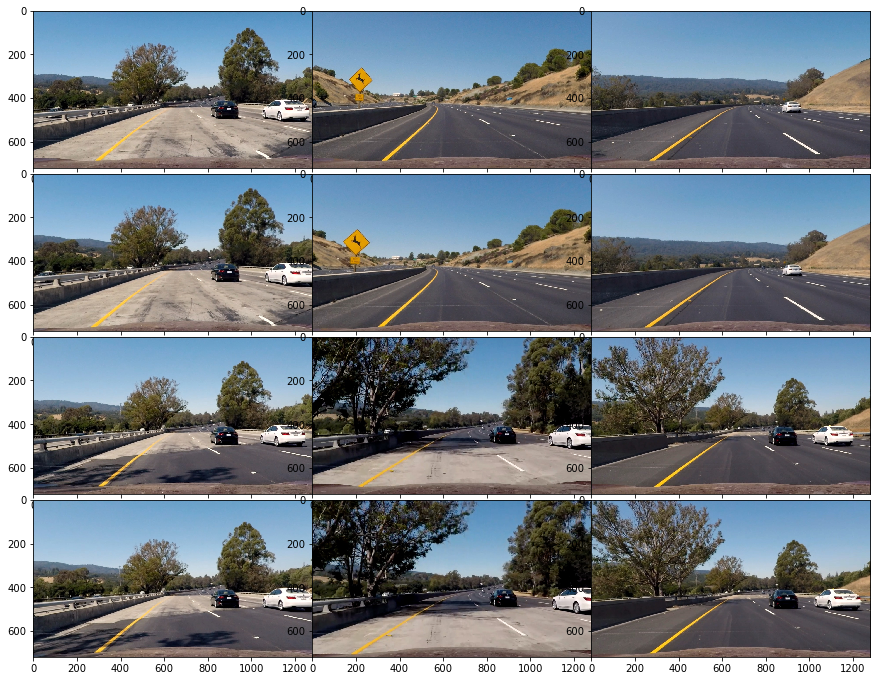

In [64]:
#visualize all distorted test images  

images = load_test_images()
image = images[0][1]
#images = load_test_video(file_name='project_video_shadow.mp4')
# images = load_test_video(file_name='project_video_short.mp4')
# @interact
def undistort_test(images):
    gs = gridspec.GridSpec(4, 3, wspace=0, hspace=0)
    n = len(images)
    fig = plt.figure(figsize=(15,12))
    for i in range(n):
        file,image = images[i]
        ax = plt.subplot(gs[2*int(i/3),np.mod(i,3)])
        plt.imshow(image)
        dst = undistort_image(image)
        ax = plt.subplot(gs[2*int(i/3)+1,np.mod(i,3)])
        plt.imshow(dst)
        
#     fig.savefig('output_images/distortedimages.png')
undistort_test(images)

In [21]:
# define binary thresholding filter based on pavement color

def binary_filter_road_pavement(img):
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # create dimensions for roi boxes - center, and left & right half height
    width=img.shape[1]
    height=img.shape[0]
    x_center=np.int(width/2)
    roi_width=100
    roi_height=200
    x_left=x_center-np.int(roi_width/2)
    x_right=x_center+np.int(roi_width/2)
    y_top=height-30
    y_bottom=y_top-roi_height
    y_bottom_small=y_top-np.int(roi_height/2)
    x_offset=50
    x_finish=width-x_offset
    
    # extract the roi and stack before converting to HSV
    roi_center=img[y_bottom:y_top, x_left:x_right]
    roi_left=img[y_bottom_small:y_top, x_offset:roi_width+x_offset]
    roi_right=img[y_bottom_small:y_top, x_finish-roi_width:x_finish]
    roi=np.hstack((roi_center,np.vstack((roi_left,roi_right))))
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    
        # calculating object histogram
    roihist = cv2.calcHist([roi_hsv],[0, 1], None, [256, 256], [0, 256, 0, 256] )
#     roihist = cv2.calcHist([roi_hsv],[0], None, [256], [0, 256] )
    
    # normalize histogram and apply backprojection
    cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
    dst = cv2.calcBackProject([img_hsv],[0,1],roihist,[0,256,0,256],1)
#     dst = cv2.calcBackProject([img_hsv],[0],roihist,[0,256],1)

    # Now convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    cv2.filter2D(dst,-1,disc,dst)
    
    # threshold and binary AND
    ret,thresh = cv2.threshold(dst,5,250,cv2.THRESH_BINARY_INV)

    return thresh

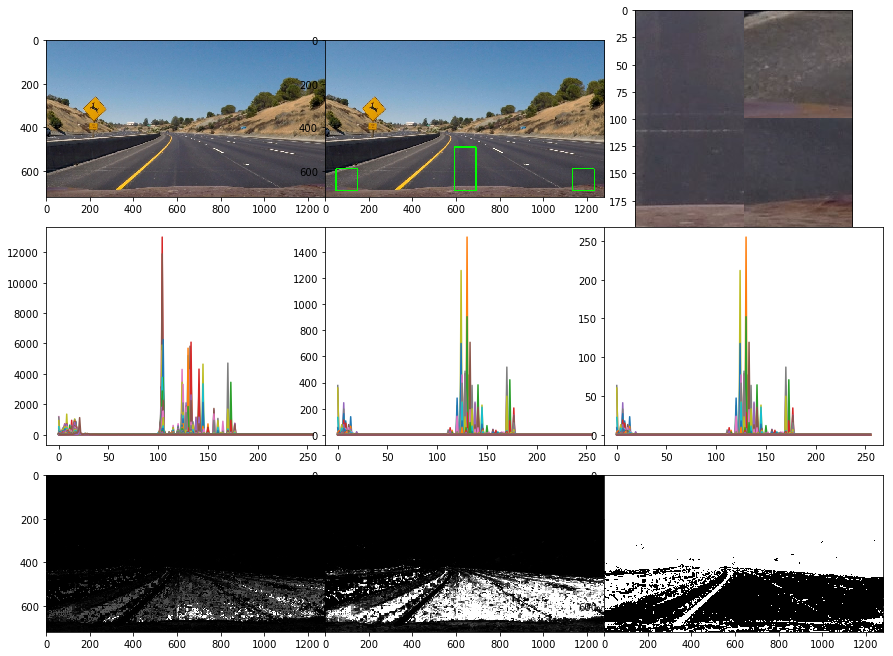

In [27]:
#visualize pavement filter thresholding method for generate binary images

img = cv2.imread('test_images/test2.jpg')
# img = images[5]
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
# plt.imshow(img)


width=img.shape[1]
height=img.shape[0]
x_center=np.int(width/2)
roi_width=100
roi_height=200
x_left=x_center-np.int(roi_width/2)
x_right=x_center+np.int(roi_width/2)
y_top=height-30
y_bottom=y_top-roi_height
y_bottom_small=y_top-np.int(roi_height/2)
x_offset=50
x_finish=width-x_offset

roi_src=np.int32([(x_left, y_top),
                        (x_left, y_bottom),
                        (x_right, y_bottom),
                        (x_right, y_top)
                       ])
roi_src_left=np.int32([(x_offset, y_top),
                        (x_offset, y_bottom_small),
                        (x_offset+roi_width, y_bottom_small),
                        (x_offset+roi_width, y_top)
                       ])
roi_src_right=np.int32([(x_finish, y_top),
                        (x_finish, y_bottom_small),
                        (x_finish-roi_width, y_bottom_small),
                        (x_finish-roi_width, y_top)
                       ])

roi_center=img[y_bottom:y_top, x_left:x_right]
roi_left=img[y_bottom_small:y_top, x_offset:roi_width+x_offset]
roi_right=img[y_bottom_small:y_top, x_finish-roi_width:x_finish]
roi=np.hstack((roi_center,np.vstack((roi_left,roi_right))))
roi_hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)


# plt.imshow(roi)

roihist_image = cv2.calcHist([img_hsv],[0,1], None, [256,256], [0,256,0,256] )
# plt.plot(roihist_image)
# print(roihist.shape)

roihist_raw = cv2.calcHist([roi_hsv],[0,1], None, [256,256], [0,256,0,256] )
# plt.plot(roihist_raw)
# print(roihist_raw.shape)
roihist = np.copy(roihist_raw)
cv2.normalize(roihist_raw,roihist,0,255,cv2.NORM_MINMAX)
# plt.plot(roihist)
# print(roihist.shape)

dst = cv2.calcBackProject([img_hsv],[0,1],roihist,[0,256,0,256],1)
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# plt.imshow(dst,cmap='gray')

dst1=cv2.filter2D(dst,-1,disc)
# plt.imshow(dst1,cmap='gray')

ret,thresh = cv2.threshold(dst1,5,250,cv2.THRESH_BINARY_INV)
# plt.imshow(thresh,cmap='gray')

img_copy = np.copy(img)
img_roi = cv2.polylines(img_copy,[roi_src],True,(0,255,0),3,8)
img_roi = cv2.polylines(img_copy,[roi_src_left],True,(0,255,0),3,8)
img_roi = cv2.polylines(img_copy,[roi_src_right],True,(0,255,0),3,8)

# plt.imshow(img_roi)


gs = gridspec.GridSpec(3, 3, wspace=0, hspace=0)
n = len(images)
fig = plt.figure(figsize=(15,12))
plt.subplot(gs[0,0])
plt.imshow(img)
plt.subplot(gs[0,1])
plt.imshow(img_roi)
plt.subplot(gs[0,2])
plt.imshow(roi)
plt.subplot(gs[1,0])
plt.plot(roihist_image)
plt.subplot(gs[1,1])
plt.plot(roihist_raw)
plt.subplot(gs[1,2])
plt.plot(roihist)
plt.subplot(gs[2,0])
plt.imshow(dst,cmap='gray')
plt.subplot(gs[2,1])
plt.imshow(dst1,cmap='gray')
plt.subplot(gs[2,2])
plt.imshow(thresh,cmap='gray')
# fig.savefig('output_images/pavementfilter_3.png')

In [28]:
# define a comprehensive thresholding function which combined grad filter, color filter, mag filter and pavement filter. 
# Also four different combinations are created to handle different image comditions

def combined_threshold(img, kernel=3, grad_thresh=(30,100), mag_thresh=(70,100), dir_thresh=(0.8, 0.9),
                       s_thresh=(100,255), r_thresh=(150,255), u_thresh=(140,180),
#                       threshold="daytime-normal"):
    threshold="daytime-filter-pavement"):

    def binary_thresh(channel, thresh = (200, 255), on = 1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

        return binary
    
    # overwrite defaults
#     if threshold == "daytime-shadow":
#         grad_thresh=(15,100)

    # check up the default red_min threshold to cut out noise and detect white lines
    if threshold in ["daytime-bright","daytime-filter-pavement"]:
         r_thresh=(210,255)
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    # calculate the scobel x gradient binary
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    gradx = binary_thresh(scaled_sobelx, grad_thresh)
    
    # calculate the scobel y gradient binary
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    grady = binary_thresh(scaled_sobely, grad_thresh)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary_thresh(gradmag, mag_thresh)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_thresh(absgraddir, dir_thresh)
    
    # HLS color
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sbinary = binary_thresh(S, s_thresh)
    
    # RGB color
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    rbinary = binary_thresh(R, r_thresh)
    
    # YUV color
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y = yuv[:,:,0]
    U = yuv[:,:,1]
    V = yuv[:,:,2]
    ubinary = binary_thresh(U, u_thresh)
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
#     combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1) | (ubinary ==1) | (rbinary == 1) ] = 1
    
    
    # combined[((gradx == 1) | (rbinary == 1)) & ( (sbinary ==1) | (ubinary ==1)| (rbinary == 1 ))] = 1
    
#     combined[((gradx == 1) | (rbinary == 1)) ] = 1
    #combined[(gradx == 1) | (ubinary == 1) | (rbinary == 1) ] = 1
    
    if threshold == "daytime-normal": 
        combined[(gradx == 1)  | (sbinary == 1) | (rbinary == 1) ] = 1
    elif threshold == "daytime-shadow":
        combined[((gradx == 1) & (grady == 1)) | (rbinary == 1)] = 1
    elif threshold == "daytime-bright":
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
    elif threshold == "daytime-filter-pavement":# default
        road_binary=binary_thresh(binary_filter_road_pavement(img))
        combined[(((gradx == 1)  | (sbinary == 1)) &(road_binary==1)) | (rbinary == 1 ) ] = 1
    else:
        combined[((gradx == 1) | (rbinary == 1)) & ( (sbinary ==1) | (ubinary ==1)| (rbinary == 1 ))] = 1
        
    return combined

In [29]:
images = load_test_images()
# images = load_test_video(file_name='project_video.mp4')
# images = load_test_video(file_name='project_video_shadow.mp4')
# images = load_test_video(file_name='project_video_short.mp4')
#images = load_test_video(file_name='challenge_video.mp4')

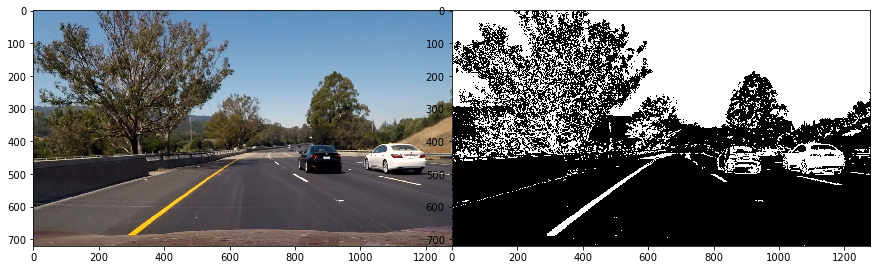

In [31]:
# interactively play around with the combined binary filter

@interact
def combined_threshold_image(images=fixed(images), i:(0,len(images)-1)=94, 
                    sobel_kernel:(3,21,2)=3,
                    grad_min:(0,255)=30, grad_max:(0,255)=100,
                    mag_min:(0,255)=70, mag_max:(0,255)=100,
                    dir_min:(0.,np.pi/2)=0.8, dir_max:(0,np.pi/2)=0.9,
                  
                    s_min:(0,255)=100, s_max:(0,255)=255,
                    r_min:(0,255)=150, r_max:(0,255)=255,
                    u_min:(0,255)=140, u_max:(0,255)=180,
                    threshold:["daytime-normal","daytime-shadow","daytime-bright","daytime-filter-pavement","other"]="daytime-normal"):
  
    file,img=images[i]
    dir_binary=combined_threshold(img, sobel_kernel,
                                  grad_thresh=(grad_min, grad_max),
                                  mag_thresh=(mag_min, mag_max),
                                  dir_thresh=(dir_min, dir_max),
                                  s_thresh=(s_min, s_max),
                                  r_thresh=(r_min, r_max),
                                  u_thresh=(u_min, u_max),
                                  threshold=threshold
                                 )
    fig = plt.figure(figsize=(15,15))
    gs = gridspec.GridSpec(1, 2, wspace=0, hspace=0)
    plt.subplot(gs[0])
    plt.imshow(img)
    plt.subplot(gs[1])
    plt.imshow(dir_binary,cmap='gray')
#     return arr2img(dir_binary)


In [56]:
# define basic functions for image warping

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (0,255,0),2,8)

def perspective_transforms(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def perspective_warp(img, M):
    img_size = (img.shape[1], img.shape[0])
#     img_size = (img.shape[0], img.shape[1])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def perspective_unwarp(img, Minv):
    img_size = (img.shape[1], img.shape[0])
#     img_size = (img.shape[0], img.shape[1])
    
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped
    
def calc_warp_points(img_height,img_width,x_center_adj=2,x_bottom_adj=26):
    
    # calculator the vertices of the region of interest
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_center_adj

    xfd=48
    yf=450
    xoffset=444
    
    src = np.float32(
        [(imshape[1]/2+x_bottom_adj-xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]/2+x_bottom_adj+xoffset,imshape[0])])
    
    dst = np.float32(
        [(imshape[1]/2+x_bottom_adj-xoffset/4,imshape[0]),
         (imshape[1]/2+x_bottom_adj-xoffset/4,0),
         (imshape[1]/2+x_bottom_adj+xoffset/4, 0),
        (imshape[1]/2+x_bottom_adj+xoffset/4,imshape[0])])
        
    return src, dst
# not used by now   

def binary_topdown_test(img, threshold="daytime-filter-pavement"):
    # camera undistort
    undistorted=undistort_image(img)
    
    # top down view warp of the undistorted binary image
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])

    # calculate matrix for perspective warp
    M, _ = perspective_transforms(src, dst)
    
    
    def noise_detect(warped):
        histogram=np.sum(warped, axis = 1)
        return (histogram > 100).any()
        
    # use the default
    if threshold == "daytime-normal":
        # this works in normal daytime conditions
        combined=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(combined, M)
        if noise_detect(warped):
            combined=combined_threshold(undistorted, threshold="daytime-shadow")
            warped = perspective_warp(combined, M)
    else:
        undistorted=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(undistorted, M)
        
    left_bot_x = 400
    right_bot_x = 940
    left_top_x = 510
    right_top_x = 830
    top_y = warped.shape[0]-1
    bot_y = 0
    
    return warped,left_bot_x,right_bot_x,left_top_x,right_top_x,top_y,bot_y

def binary_topdown(img, threshold="daytime-filter-pavement"):
    # camera undistort
    undistorted=undistort_image(img)
    
    # top down view warp of the undistorted binary image
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])

    # calculate matrix for perspective warp
    M, _ = perspective_transforms(src, dst)
    
    
    def noise_detect(warped):
        histogram=np.sum(warped, axis = 1)
        return (histogram > 100).any()
        
    # use the default
    if threshold == "daytime-normal":
        # this works in normal daytime conditions
        combined=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(combined, M)
        if noise_detect(warped):
            combined=combined_threshold(undistorted, threshold="daytime-shadow")
            warped = perspective_warp(combined, M)
    else:
        undistorted=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(undistorted, M)
        
    top_y = warped.shape[0]-1
    left_bot_x = 400
    right_bot_x = 940
    left_top_x = 510
    right_top_x = 830
    bot_y = 0
    X_m = np.mgrid[0:img.shape[0],0:img.shape[1]][1]
    Y_m = np.mgrid[0:img.shape[0],0:img.shape[1]][0]
    warped[(X_m-left_top_x)*(bot_y-top_y) >= (Y_m-top_y)*(left_bot_x-left_top_x)]=0
    warped[(X_m-right_top_x)*(bot_y-top_y) <= (Y_m-top_y)*(right_bot_x-right_top_x)]=0
    return warped

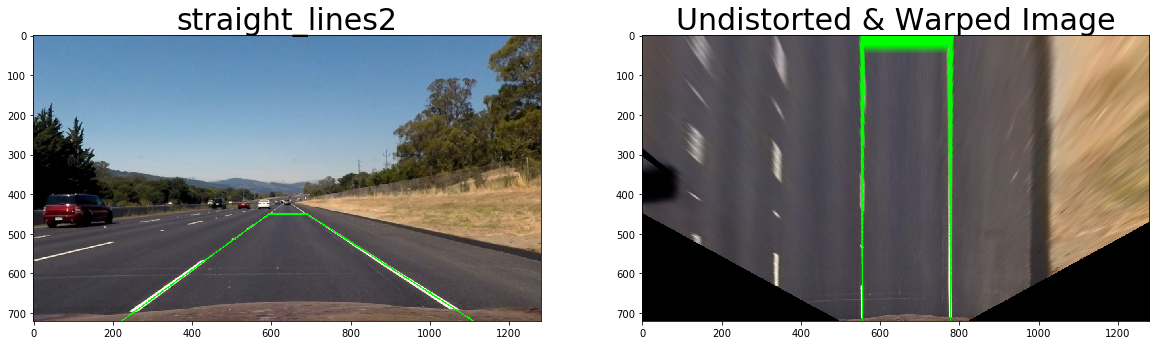

In [35]:
# interactively play around with image warping and filtering

images = []
images.append(('straight_lines2',cv2.cvtColor(cv2.imread('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)))
images.append(('straight_lines1',cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)))
# images = load_test_video()
# images = load_test_video(file_name='project_video_shadow.mp4')

@interact
def transform_test(images=fixed(images), i:(0,len(images)-1)=0, threshold_flag:(False,True)=False):
    file,img=images[i]
    undistorted=undistort_image(img)
    if threshold_flag:
        undistorted=combined_threshold(undistorted)
    #vertices=[(700,200), (700,1100), (400,700), (400,500)]
    
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])
    M, _ = perspective_transforms(src, dst)
    draw_lines(undistorted,src)
    
    warped = perspective_warp(undistorted, M)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undistorted, cmap="gray")
    ax1.set_title(file, fontsize=30)
    ax2.imshow(warped, cmap="gray")
    ax2.set_title('Undistorted & Warped Image', fontsize=30)
    
#     f.savefig('output_images/straightlines2.png', bbox_inches='tight')

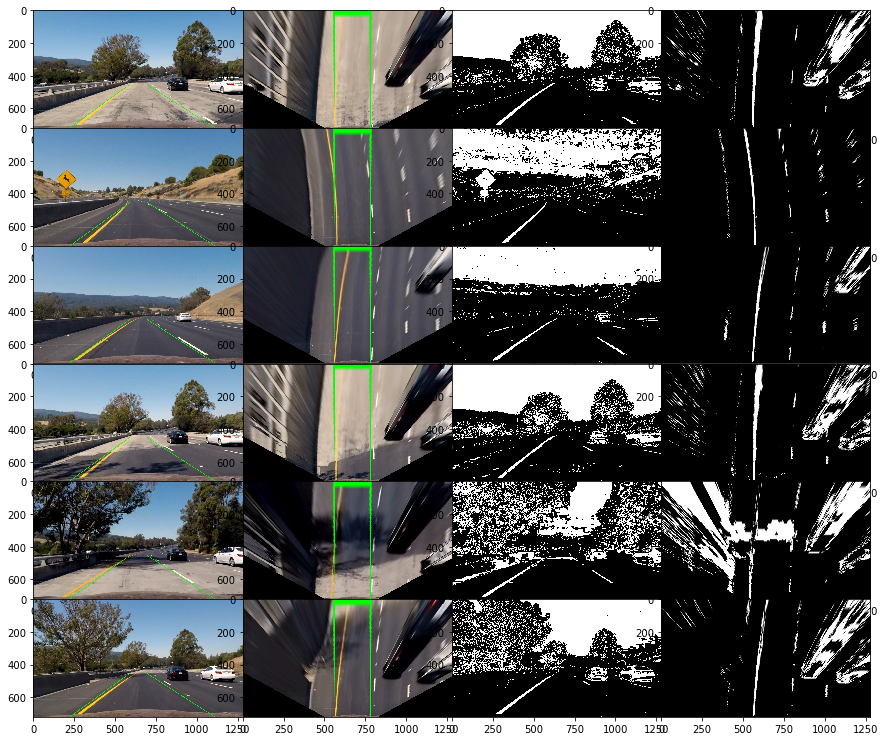

In [36]:
# visualize combined effect of warping and thresholding on all test images

def transform_test_visualization(images):
    
    gs = gridspec.GridSpec(len(images), 4, wspace=0, hspace=0)
    fig = plt.figure(figsize=(15,13))
    
    for i in range(len(images)):
        file,img=images[i]
        undistorted=undistort_image(img)
        undistorted_binary=combined_threshold(undistorted,threshold='daytime-filter-pavement')
        
        src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])
        M, _ = perspective_transforms(src, dst)
        draw_lines(undistorted,src)

        warped = perspective_warp(undistorted, M)
        warped_binary = perspective_warp(undistorted_binary, M)
        
        # Visualize undistortion
        plt.subplot(gs[i,0])
        plt.imshow(undistorted, cmap="gray")
        plt.subplot(gs[i,1])
        plt.imshow(warped, cmap="gray")
        plt.subplot(gs[i,2])
        plt.imshow(undistorted_binary, cmap="gray")
        plt.subplot(gs[i,3])
        plt.imshow(warped_binary, cmap="gray")
        
#         fig.savefig('output_images/warpedtestimages.png')
        
images = load_test_images()
transform_test_visualization(images)


In [51]:
# define all functions and classes for lane searching on warped binary images

from scipy import signal

def lane_histogram(img, lower=0.4):
    
    height_start = img.shape[0]*(1-lower)
    height_end = img.shape[0]
    
    histogram = np.sum(img[int(height_start):int(height_end),:], axis=0)
    
    return histogram

def lane_peaks(histogram):
    peaks = list(signal.find_peaks_cwt(histogram, np.arange(1,150)))
    midpoint = np.int(histogram.shape[0]/2)
    # if we found at least two peaks use the signal approach (better in shadows)
    if len(peaks) > 1:
        # in case more than 2 found just get the left and right one
        peak_left = peaks[np.argmax(np.asarray(peaks)>520)]
        peaks.reverse()
        peak_right = peaks[np.argmax(np.asarray(peaks)<820)]
    # otherwise just choose the highest points in left and right of center segments
    else:
       
        peak_left = np.argmax(histogram[:midpoint])
        peak_right = np.argmax(histogram[midpoint:]) + midpoint
    
    return peak_left, peak_right

class WindowBox(object):
    def __init__(self, binimg, x_center, y_top, width=100, height=80, mincount=50, lane_found=False):
        self.x_center = x_center
        self.y_top = y_top
        self.width = width
        self.height = height
        self.mincount = mincount
        self.lane_found = lane_found
        
        # derived
        self.x_left = self.x_center - int(self.width/2)
        self.x_right = self.x_center + int(self.width/2)
        self.y_bottom = self.y_top - self.height   
        self.imgwindow = binimg[self.y_bottom:self.y_top,
                                self.x_left:self.x_right]
        self.nonzeroy = self.imgwindow.nonzero()[0]
        self.nonzerox = self.imgwindow.nonzero()[1]
         
    def center(self):
        return (self.x_center, int(self.y_top-self.y_bottom)/2)
    
    def next_windowbox(self, binimg):
        if self.has_line():
            # recenter based on mean
            x_center = np.int(np.mean(self.nonzerox + self.x_left))
        else:
            # use existing center
            x_center = self.x_center
            
        # next box top starts at lasts bottom
        y_top = self.y_bottom 
        
        return WindowBox(binimg, x_center, y_top, 
                         width=self.width, height=self.height, mincount = self.mincount,
                         lane_found=self.lane_found)
    def _nonzerox_count(self):
        return len(self.nonzerox)
    
    def _is_noise(self):
        return self._nonzerox_count() > self.imgwindow.shape[0] * self.imgwindow.shape[1] *.75
        
    def has_line(self):
        return (self._nonzerox_count() > self.mincount) ^ self._is_noise()
    
    def has_lane(self):
        if not self.lane_found and self.has_line():
            self.lane_found = True
        return self.lane_found
        
    def __str__(self):
        return "WindowBox [%.3f, %.3f, %.3f, %.3f]" % (self.x_left,
                                                       self.y_bottom,
                                                       self.x_right,
                                                       self.y_top)



def find_lane_windows(window_box, binimg):
    boxes=[]

    # keep searching up the image for a lane line and append the boxes
    continue_lane_search = True
    contiguous_box_no_line_count = 0
    while (continue_lane_search and window_box.y_top >= 0):
        if window_box.has_line():
            boxes.append(window_box)

        window_box=window_box.next_windowbox(binimg)

        # if we've found the lane and can no longer find a box with a line in it
        # then its no longer worth while searching
        if window_box.has_lane():
            if window_box.has_line():
                contiguous_box_no_line_count = 0
            else:
                contiguous_box_no_line_count += 1
                
                if contiguous_box_no_line_count >= 4:
                    continue_lane_search = False

    return boxes
    
def calc_lane_windows(binimg, nwindows=12, width=100):
    
    # calc height of each window
    height = np.int(binimg.shape[0]/nwindows)
    
    # find left and right lane centers to start with
    peak_left, peak_right = lane_peaks(lane_histogram(binimg))

    
    # Initialise left and right window boxes
    ytop = binimg.shape[0]

    wbl = WindowBox(binimg, peak_left, ytop, width=width, height=height)
#     left_boxes = find_lane_windows(wbl, binimg)
    
    wbr = WindowBox(binimg, peak_right, ytop, width=width, height=height)
#     right_boxes = find_lane_windows(wbr, binimg)

    # paralleise the search
    find_lane_windows_binimg = partial(find_lane_windows, binimg=binimg)
    with Pool(2) as p:
        left_boxes, right_boxes = p.map(find_lane_windows_binimg, [wbl, wbr])

    return (left_boxes, right_boxes)



def calc_fit_from_boxes(boxes):
    if len(boxes) > 0:
        # flaten and adjust all boxes for the binary images
        xs = np.concatenate([b.nonzerox + b.x_left for b in boxes ])
        ys = np.concatenate([b.nonzeroy + b.y_bottom for b in boxes])
        
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    else:
        return None
        
    

def poly_fitx(fity, line_fit):
    fit_linex = line_fit[0]*fity**2 + line_fit[1]*fity + line_fit[2]
    return fit_linex

def calc_lr_fit_from_polys(binimg, left_fit, right_fit, margin=100):
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    def window_lane(poly):
        return (
            (nonzerox > (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] - margin)) 
            & (nonzerox < (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] + margin))
        )
    
    def window_polyfit(lane_inds):
        xs = nonzerox[lane_inds]
        ys = nonzeroy[lane_inds]
       
        # return the polynominal
        return np.polyfit(ys, xs, 2)
    
    new_left_fit = left_fit
    if left_fit is not None: 
        new_left_fit = window_polyfit(window_lane(left_fit))
        
    new_right_fit =  right_fit
    if right_fit is not None: 
        new_right_fit = window_polyfit(window_lane(right_fit)) 
    
    return (new_left_fit, new_right_fit)

In [39]:
images = load_test_images()
# images = load_test_video(file_name='project_video_short.mp4')
# images = load_test_video(file_name='project_video.mp4')
# images = load_test_video(file_name='project_video_shadow.mp4')
# images = load_test_video(file_name='challenge_video.mp4')

555
776


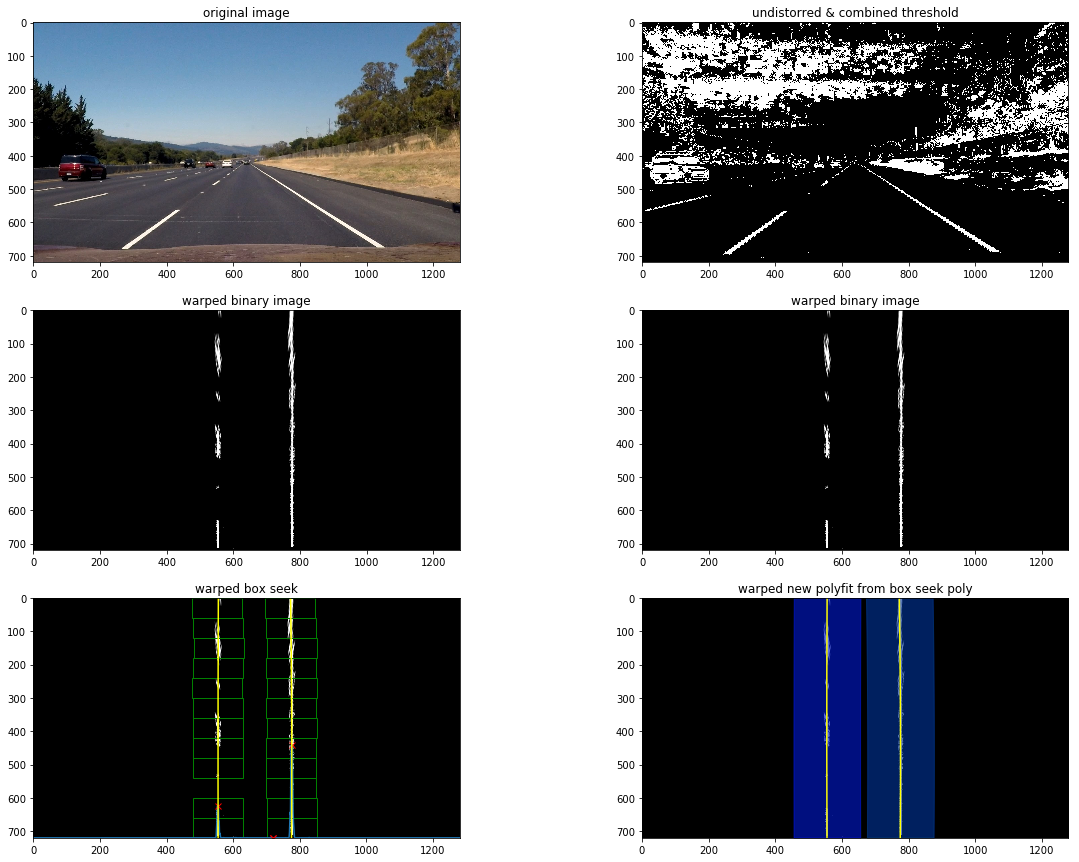

In [52]:
# visualize line searching on warped binary images from provided test images with straight lanes. 
# Also use this to determined the ratio of pixel to real distance  

import matplotlib.patches as patches

images = []
images.append(('straight_lines2',cv2.cvtColor(cv2.imread('test_images/straight_lines2.jpg'), cv2.COLOR_BGR2RGB)))
images.append(('straight_lines1',cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)))
@interact
def topdown_histogram_test(images=fixed(images), i:(0,len(images)-1)=0):
    file,img=images[i]
    topdown_binary_img = binary_topdown(img)
    height=topdown_binary_img.shape[0]
    histogram = lane_histogram(topdown_binary_img)
    peak_left, peak_right = lane_peaks(histogram)
    print(peak_left)
    print(peak_right)
    boxes_left, boxes_right = calc_lane_windows(topdown_binary_img,width=150)

    left_fit = calc_fit_from_boxes(boxes_left)
    right_fit = calc_fit_from_boxes(boxes_right)
    
    # Generate x and y values for plotting
    fity = np.linspace(0, height-1, height)
    if left_fit is not None: 
        fit_leftx = poly_fitx(fity, left_fit)
    if right_fit is not None: 
        fit_rightx = poly_fitx(fity, right_fit)
    
    margin=100
    new_left_fit, new_right_fit = calc_lr_fit_from_polys(topdown_binary_img, left_fit, right_fit, margin)
    if new_left_fit is not None:
        new_leftx = poly_fitx(fity, new_left_fit)
    if new_right_fit is not None:    
        new_rightx = poly_fitx(fity, new_right_fit)
    
    f, ((ax3,ax4),(ax5, ax6),(ax1, ax2)) = plt.subplots(3, 2, figsize=(20,15))
    ax1.set_title("warped box seek")
    ax1.imshow(topdown_binary_img,cmap='gray')
    ax1.plot(height-histogram)
    ax1.plot((height,peak_left), (height,height-histogram[peak_left]), 'rx')
    ax1.plot((height,peak_right), (height,height-histogram[peak_right]), 'rx')
    for b in boxes_left + boxes_right:
        ax1.add_patch(patches.Rectangle((b.x_left, b.y_bottom),b.width,b.height,facecolor="none",edgecolor="green"))
    if left_fit is not None:
        ax1.plot(fit_leftx, fity, color='yellow')
    if right_fit is not None:
        ax1.plot(fit_rightx, fity, color='yellow')
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(720, 0)
    
    ax2.set_title("warped new polyfit from box seek poly")
    ax2.imshow(topdown_binary_img,cmap='gray')
    ax2.set_xlim(0, 1280)
    ax2.set_ylim(720, 0)
    if new_left_fit is not None:
        ax2.plot(new_leftx, fity, color='yellow')
        ax2.fill_betweenx(fity, new_leftx-margin,new_leftx+margin,alpha=0.25,color='green')
    if left_fit is not None:    
        ax2.fill_betweenx(fity, fit_leftx-margin,fit_leftx+margin,alpha=0.5,color='blue')
    if new_right_fit is not None:
        ax2.plot(new_rightx, fity, color='yellow')
        ax2.fill_betweenx(fity, fit_rightx-margin,fit_rightx+margin,alpha=0.5,color='blue')
    if right_fit is not None:
        ax2.fill_betweenx(fity, new_rightx-margin,new_rightx+margin,alpha=0.25,color='green')
    
    ax3.set_title("original image")
    ax3.imshow(img)
    
    ax4.set_title("undistorred & combined threshold")
    ax4.imshow(combined_threshold(undistort_image(img)),cmap='gray')
    
    ax5.set_title("warped binary image")
    ax5.imshow(topdown_binary_img,'gray')
    
    ax6.set_title("warped binary image")
    ax6.imshow(topdown_binary_img,'gray')
#     f.savefig('output_images/straight_lane_for_real_distance.png')

In [53]:
# define a function to calculate curvature from the fitted poly line

def calc_curvature(poly, height=720):
    
    fity = np.linspace(0, height-1, num=height)
    y_eval = np.max(fity)
   
    # assume:
    # 1 dash line + space = 40 ft
    # lane width = 12 ft
    
    # Define conversions in x and y from pixels space to meters
    # y_ft_per_pix = 105/720 = 0.146 ft/pxi # fts per pixel in y dimension
    # x_ft_per_pix = 12 / (776-555) = 0.054 ft/pxi  # fts per pixel in x dimension
    
    
    y_ft_per_pix = 105/720
    x_ft_per_pix = 12 / (776-555)
    
    def fit_in_ft(poly):
        xs = poly_fitx(fity, poly)
        xs = xs[::-1] # Reverse to match top-to-bottom in y
        
        return np.polyfit(fity*y_ft_per_pix, xs*x_ft_per_pix, 2)
    
    if poly is None:
        return .0
    
    poly_cr = fit_in_ft(poly)
    curveradft = ((1 + (2*poly_cr[0]*y_eval*y_ft_per_pix + poly_cr[1])**2)**1.5) / np.absolute(2*poly_cr[0])
    
    return curveradft

def fit_window(binimg, poly, margin=45):
    height = binimg.shape[0]
    y = binimg.shape[0]
   
    nonzero = binimg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fity = np.linspace(0, height-1, height)
    
    def window_lane(poly):
        return (
            (nonzerox > (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] - margin)) 
            & (nonzerox < (poly[0]*(nonzeroy**2) + poly[1]*nonzeroy + poly[2] + margin))
        )
    
    def fit(lane_inds):
        xs = nonzerox[lane_inds]
        #xs = xs[::-1] # Reverse to match top-to-bottom in y
        
        return np.polyfit(fity, xs, 2)
    
    return fit(window_lane(poly))

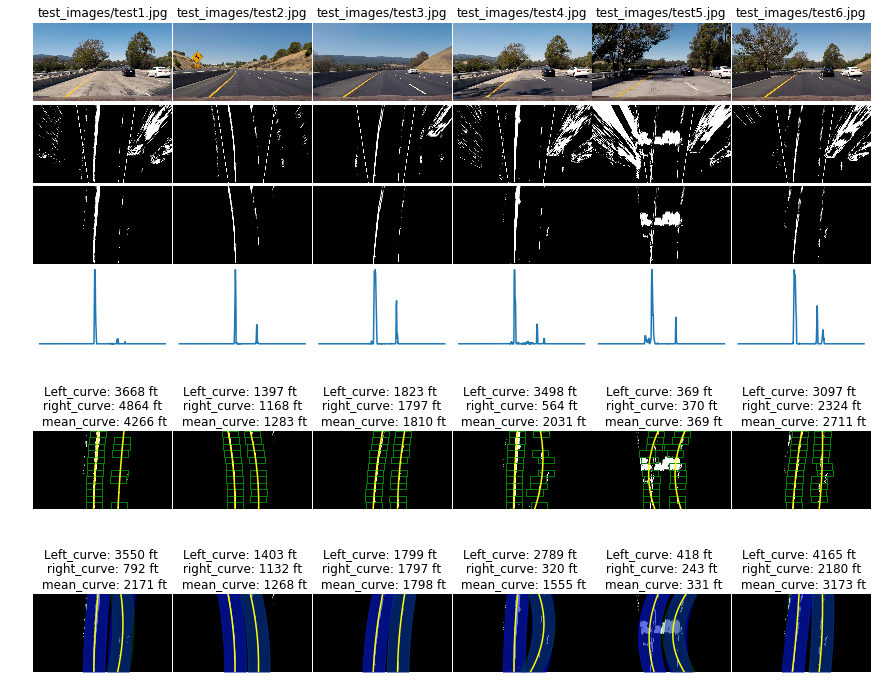

In [58]:
# visualize the entire frame-wise process on test images.
# From raw input images to final curvatures 

import matplotlib.patches as patches

images = load_test_images()
gs = gridspec.GridSpec(8, len(images) )
gs.update(wspace=0.01, hspace=0)
fig = plt.figure(figsize=(15,12))

for i in range(len(images)):
    file,img=images[i]
    topdown_binary_img = binary_topdown(img)
    
    topdown_binary_img_1,left_bot_x,right_bot_x,left_top_x,right_top_x,top_y,bot_y = binary_topdown_test(img)
    pts_left=np.int32([(left_bot_x,bot_y),(left_top_x,top_y)])
    pts_right=np.int32([(right_bot_x,bot_y),(right_top_x,top_y)])
    cv2.polylines(topdown_binary_img_1,[pts_left],True,(1,1,1),3,8)
    cv2.polylines(topdown_binary_img_1,[pts_right],True,(1,1,1),3,8)
    
    height=topdown_binary_img.shape[0]
    histogram = lane_histogram(topdown_binary_img)
    peak_left, peak_right = lane_peaks(histogram)

    boxes_left, boxes_right = calc_lane_windows(topdown_binary_img,width=150)

    left_fit = calc_fit_from_boxes(boxes_left)
    right_fit = calc_fit_from_boxes(boxes_right)
    
    # Generate x and y values for plotting
    fity = np.linspace(0, height-1, height)
    if left_fit is not None: 
        fit_leftx = poly_fitx(fity, left_fit)
    if right_fit is not None: 
        fit_rightx = poly_fitx(fity, right_fit)
    
    margin=100
    new_left_fit, new_right_fit = calc_lr_fit_from_polys(topdown_binary_img, left_fit, right_fit, margin)
    if new_left_fit is not None:
        new_leftx = poly_fitx(fity, new_left_fit)
    if new_right_fit is not None:    
        new_rightx = poly_fitx(fity, new_right_fit)
    
    ax0 = plt.subplot(gs[0,i])
    ax0.set_title(file)
    plt.imshow(img)
    
    ax1 = plt.subplot(gs[1,i])
#     ax1.set_title("binary_warped_img")
    plt.imshow(topdown_binary_img_1,cmap='gray')
    
    ax2 = plt.subplot(gs[2,i])
#     ax1.set_title("binary_warped_img")
    plt.imshow(topdown_binary_img,cmap='gray')
    
    ax3 = plt.subplot(gs[3,i])
#     ax2.set_title("histogram for inital lane")
    plt.plot(histogram)
    
    ax4 = plt.subplot(gs[5,i])
#     ax3.set_title("search from sliding window")
    ax4.imshow(topdown_binary_img,cmap='gray')

    for b in boxes_left + boxes_right:
        ax4.add_patch(patches.Rectangle((b.x_left, b.y_bottom),b.width,b.height,facecolor="none",edgecolor="green"))
    if left_fit is not None:
        ax4.plot(fit_leftx, fity, color='yellow')
        curv_left = calc_curvature(left_fit, height)
    if right_fit is not None:
        ax4.plot(fit_rightx, fity, color='yellow')
        curv_right = calc_curvature(right_fit, height)
    ax4.set_title("Left_curve: %d ft \n right_curve: %d ft \n mean_curve: %d ft" % (curv_left, curv_right, (curv_left+curv_right)/2))
    ax4.set_xlim(0, 1280)
    ax4.set_ylim(720, 0)
    
    
    ax5 = plt.subplot(gs[7,i])
#     ax4.set_title("search from existing poly")
    ax5.imshow(topdown_binary_img,cmap='gray')
    ax5.set_xlim(0, 1280)
    ax5.set_ylim(720, 0)
    if new_left_fit is not None:
        ax5.plot(new_leftx, fity, color='yellow')
        ax5.fill_betweenx(fity, new_leftx-margin,new_leftx+margin,alpha=0.25,color='green')
        curv_left = calc_curvature(new_left_fit, height)
    if left_fit is not None:    
        ax5.fill_betweenx(fity, fit_leftx-margin,fit_leftx+margin,alpha=0.5,color='blue')
    if new_right_fit is not None:
        ax5.plot(new_rightx, fity, color='yellow')
        ax5.fill_betweenx(fity, fit_rightx-margin,fit_rightx+margin,alpha=0.5,color='blue')
        curv_right = calc_curvature(new_right_fit, height)
    if right_fit is not None:
        ax5.fill_betweenx(fity, new_rightx-margin,new_rightx+margin,alpha=0.25,color='green')
    ax5.set_title("Left_curve: %d ft \n right_curve: %d ft \n mean_curve: %d ft" % (curv_left, curv_right, (curv_left+curv_right)/2))              
                  
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax5.axis('off')
    
# fig.savefig('output_images/test_images_lane_found.png')

In [74]:
# define three main classes: Line(), RoadLine() and Lane() to handle video-wise processing

from collections import deque

# holds current line details
class Line():
    """Line Class"""
    LINE_FIT_INVALID_MSG = "Line has an invalid polynominal." 
    def __init__(self, ploty, poly_fit, binimg):
        self.__ploty = ploty
        self.__poly_fit = poly_fit
        self.__binimg = binimg
        
        # derived
        self.__curvature = None
        self.__y_bottom = np.min(ploty)
        self.__y_top = np.max(ploty)
        
        try:
            self.__x_bottom = poly_fitx(self.__y_bottom, self.poly_fit)
            self.__x_top = poly_fitx(self.__y_top, self.poly_fit)
        except TypeError:
            raise ValueError(Line.LINE_FIT_INVALID_MSG)
                
        
    @property
    def xs(self):
        return poly_fitx(self.ploty, self.poly_fit)
    
    @property
    def ploty(self):
        return self.__ploty
    
    @property
    def poly_fit(self):
        return self.__poly_fit
    
    @property
    def binimg(self):
        return self.__binimg
    
    @property
    def y_bottom(self):
        return self.__y_bottom
    
    @property
    def y_top(self):
        return self.__binimg.shape[1]
    
    @property
    def x_bottom(self):
        return self.__x_bottom

    @property
    def x_top(self):
        return self.__x_top
    
    @property
    def curvature(self):
        if self.__curvature is None:
            self.__curvature = calc_curvature(self.poly_fit)
        return self.__curvature
    
    def __str__(self):
        return "Line(%.3f, %s, bot:(%d,%d) top:(%d,%d))" % (self.curvature,
                                                            self.poly_fit,
                                                            self.x_bottom, self.y_bottom,
                                                            self.x_top, self.y_top)
                                                       
    
# contains the Line details and methods to determine current road line
class RoadLine():
    """RoadLine Class"""
    LINE_ISNT_SANE_MSG = "Line didn't pass sanity checks." 
    
    def __init__(self, line, line_history_max=6):
        # initialise class
        self.__line_history = deque([])
                
        self.__all_curvatures = None
        
        # assign constructor variables
        self.line_history_max = line_history_max
        self.line = line # must have at 
    
    def __str__(self):
        return "RoadLine(%s, mean_fit=%s, mean_curvature=%.3f, history=[%s])" % (self.line,  
                                                              self.mean_fit,
                                                              self.mean_curvature,                    
                                                              ', '.join([str(l.curvature) for l in self.__line_history]))
    @property
    def line(self):
        if len(self.__line_history) > 0:
            return self.__line_history[-1]
        else:
            return None
    
    @line.setter
    def line(self, line):
        
        def xs_are_near(x1,x2, limit=100):
            return np.abs(x1-x2) < limit
        
        def is_line_sane(line):
            try:
                line_prev = self.line
                
                # top is near car
                if not xs_are_near(line.x_top,line_prev.x_top):
                    raise ValueError("top xs weren't near")
                
                # bottom is horizon
                if not xs_are_near(line.x_bottom,line_prev.x_bottom):
                    raise ValueError("bottom xs weren't near")
                
            # if line doesnt cross at y_bottom isnt an ellipse which should through a ValueError
            except ValueError as err:
                print("value error: {0}".format(err))
                return False
            
            return True
            
        if len(self.__line_history) > 0 and not is_line_sane(line):
            raise ValueError(self.LINE_ISNT_SANE_MSG)
            
        self._queue_to_history(line)
        
            
        
    def _queue_to_history(self, line):
        self.__line_history.append(line)
        self.__all_curvatures = None # will get recreated lazily
        # only keep the last lines appended
        if self.line_history_count > self.line_history_max:
            self.__line_history.popleft()
        
    @property
    def line_history_count(self):
        return len(self.__line_history) 
    
    @property
    def curvature(self):
        return self.line.curvature
    
    @property
    def curvatures(self):
        if self.__all_curvatures is None:
            self.__all_curvatures = np.array([line.curvature for line in self.__line_history])
        return self.__all_curvatures
    
    @property
    def mean_curvature(self):
        return np.mean(self.curvatures)
    
    @property
    def std_curvature(self):
        return np.std(self.curvatures)
    
    @property
    def max_abs_curvature_variance(self):
        return np.max(np.abs(self.curvatures-np.mean(self.curvatures)))
    
    @property
    def line_fits(self):
        return np.array([line.poly_fit for line in self.__line_history])
    
    @property
    def mean_fit(self):
        lf=self.line_fits
        nweights=len(lf)
        
        weights = None
        # if just one no need for weights
        if nweights > 1:
            # if two then give more weight to the newer
            if nweights == 2:
                weights = [.60,.40]
            # otherwise start with two and pad out evenly the remainder
            else:
                weights = [.40,.30]

                # pad out the weights 
                if nweights > len(weights):
                    weights=np.pad(weights,(0,nweights-len(weights)),'constant', 
                             constant_values=(1-np.sum(weights))/(nweights-len(weights)))
            
            
        return np.average(lf, weights=weights, axis=0)
       
    @property
    def ploty(self):
        # will all have same ploty
        return self.line.ploty
    
    @property
    def mean_xs(self):
        return poly_fitx(self.ploty, self.mean_fit)
            

    
# contains the left & right road lines and associated image 
class Lane():
    """Lane Class"""
    
    y_ft_per_pix = 105/720
    x_ft_per_pix = 12 / (776-555)
    #lane_px_width=413
    #xm_per_pix = 3.7/lane_px_width # meters per pixel in x dimension - copied from calc_curvature for convenience

    THRESHOLD_DAYTIME_NORMAL = "daytime-normal"
    THRESHOLD_DAYTIME_SHADOW = "daytime-shadow"
    THRESHOLD_DAYTIME_BRIGHT = "daytime-bright"
    THRESHOLD_DAYTIME_FILTER = "daytime-filter-pavement"
    THRESHOLD_WINDOWING = "windowing"
    
    def __init__(self, img_height, img_width, mtx, dist):
        self.__img_height = img_height
        self.__img_width = img_width
        
        # camera callibration
        self.__mtx = mtx
        self.__dist = dist

        # set images to None
        self.__image = None 
        self.__undistorted_image = None
        self.__binary_image = None
        self.__warped = None
        self.__warped_threshold = self.THRESHOLD_DAYTIME_FILTER

        # warp points and transformation matrices
        warp_src, warp_dst = calc_warp_points(img_height, img_width)
        self.__warp_src = warp_src
        self.__warp_dst = warp_dst
        M, Minv = perspective_transforms(warp_src, warp_dst)
        self.__M = M
        self.__Minv = Minv
        
        # arrays for plotting
        #self.__ploty = np.linspace(0,img_height-1, img_height)
        # warped image has been rotated by 90% to give longer lines
        warped_height=img_height #img_width
        self.__ploty = np.linspace(0,warped_height-1, warped_height)
        self.__pts_zero = np.zeros((1,warped_height,2),dtype=np.int)
        
        # place holders for the road lines - cant initialise until we have a camera image
        self.__road_line_left = None
        self.__road_line_right = None
           
    @property
    def img_height(self):
        return self.__img_height
    @property
    def img_width(self):
        return self.__img_width  
    
    @property
    def pts_zero(self):
        return self.__pts_zero
    
    @property 
    def ploty(self):
        return self.__ploty

    @property
    def undistorted_image(self):
        return self.__undistorted_image
        
    @property
    def binary_image(self):
        return self.__binary_image
    
    @property
    def warped(self):
        return self.__warped
    
    @property
    def warped_threshold(self):
        return self.__warped_threshold
    
    @property
    def warped_decorated(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        warp_ff=np.array(self.warped * 255).astype(np.uint8)
        warp_colour = np.dstack((warp_zero, warp_zero, warp_zero))
        img_warp= np.dstack((warp_ff, warp_ff, warp_ff)).astype(np.uint8)
        
        ploty = self.ploty
        
        width=self.warped.shape[1]
        height=self.warped.shape[0]      
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.road_line_left.mean_xs, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.road_line_right.mean_xs, ploty])))])
        pts = np.hstack((pts_left, pts_right))      
        # Draw the lane onto the warped blank image
        cv2.fillPoly(warp_colour, np.int_([pts]), (0, 255, 0))
        
        # draw the lane histogram
        histogram = self.warped_histogram
        hist_pts=[[i, height-histogram[i]] for i in range(0,width -1)]
   
        cv2.polylines(img_warp,np.int_([hist_pts]), False, (0,0,255))      
        #main
        result = self.result_decorated
        mainDiagScreen = result
        #1
        image_raw = self.image
        diag1 = image_raw
        #2
        undistorted = self.undistorted_image
        diag2 = undistorted
        #3
        binimg_ff = np.array(self.binary_image * 255).astype(np.uint8)
        undistorted_binary = np.dstack((binimg_ff, binimg_ff, binimg_ff))
        diag3 = undistorted_binary
        #4
        binimg_ff = np.array(self.warped * 255).astype(np.uint8)
        undistorted_binary_warped = np.dstack((binimg_ff, binimg_ff, binimg_ff))  
        diag4 = undistorted_binary_warped
        #5
        diag5 = undistorted_binary_warped
        #6
        hist = self.warped_histogram
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        for i in range(warp_zero.shape[1]):
            start = int(warp_zero.shape[0]-hist[i]/0.6+1)
            warp_zero[start:,i] = 255
        undistorted_binary_warped_hist = np.dstack((warp_zero, warp_zero, warp_zero))
        diag6 = undistorted_binary_warped_hist
        
        #7
        binary_warped_lane_result = cv2.addWeighted(img_warp, .7,warp_colour, 0.3, 0)
        binary_warped_lane_result = cv2.putText(binary_warped_lane_result,'%s' % self.warped_threshold, (5, 20), font, 1,(255,255,255),1,cv2.LINE_AA)
        diag7 = binary_warped_lane_result

        #8
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        diag8 = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([self.road_line_left.mean_xs, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.road_line_right.mean_xs, ploty])))])
        pts = np.hstack((pts_left, pts_right)) 
        cv2.polylines(diag8,np.int_([pts]), False, (255,255,0),5,8)
        
        #9
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        diag9 = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([self.road_line_left.line.xs, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.road_line_right.line.xs, ploty])))])
        pts = np.hstack((pts_left, pts_right)) 
        cv2.polylines(diag9,np.int_([pts]), False, (255,255,0),5,8)

 
        font = cv2.FONT_HERSHEY_COMPLEX
        middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
        lane_c = 0.5*(self.road_line_left.mean_curvature+self.road_line_right.mean_curvature)
        cv2.putText(middlepanel, 'Estimated lane curvature: %0.2f ft' % lane_c, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(middlepanel, 'Estimated feet right of center: %0.2f ft' % self.x_center_offset, (30, 90), font, 1, (255,0,0), 2)

        # assemble the screen example
        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagScreen[0:720, 0:1280] = mainDiagScreen
        diagScreen[0:240, 1280:1600] = cv2.resize(diag1, (320,240), interpolation=cv2.INTER_AREA) 
        diagScreen[0:240, 1600:1920] = cv2.resize(diag2, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1280:1600] = cv2.resize(diag3, (320,240), interpolation=cv2.INTER_AREA)
        diagScreen[240:480, 1600:1920] = cv2.resize(diag4, (320,240), interpolation=cv2.INTER_AREA)*4
        diagScreen[600:1080, 1280:1920] = cv2.resize(diag7, (640,480), interpolation=cv2.INTER_AREA)*4
        diagScreen[720:840, 0:1280] = middlepanel
        diagScreen[840:1080, 0:420] = cv2.resize(diag5, (420,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 420:840] = cv2.resize(diag6, (420,240), interpolation=cv2.INTER_AREA)
        diagScreen[840:1080, 840:1260] = cv2.resize(diag9, (420,240), interpolation=cv2.INTER_AREA)
#         diagScreen[840:1080, 960:1280] = cv2.resize(diag8, (320,240), interpolation=cv2.INTER_AREA)

        return diagScreen
    
    @property
    def road_line_left(self):
        return self.__road_line_left
   
    @property
    def road_line_right(self):
        return self.__road_line_right
    
    @property
    def result(self):
        result = self._draw_lanes_unwarped()
        return result
    
    @property
    def result_decorated(self):
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        rll, rlr = self.road_line_left, self.road_line_right
        cl, clm = rll.curvature, rll.mean_curvature
        cr, crm = rlr.curvature, rlr.mean_curvature
        xcoffset = self.x_center_offset
        
        result = self.result
        result = cv2.putText(result,'By Tingting Huang (Aug-19-2017)', (5,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
#         result = cv2.putText(result,'%0.2f ft,%0.2f ft' % (cr,crm), (800,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(result,'%.3f ft' % xcoffset, (640, 700), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        return result
    
    @property
    def image(self):
        return self.__image
    
    def _image_yuv_equalize(self, image): 
        yuv=cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))
        yuv[0]=cv2.equalizeHist(yuv[0])
        return cv2.cvtColor(cv2.merge(yuv), cv2.COLOR_YUV2RGB)

    @image.setter
    def image(self, image):
        # make sure its a bgr image being passed in
        self.__image = image
        undistorted = undistort_image(self.__image, self.__mtx, self.__dist)
        self.__undistorted_image = undistorted
           
        # look for a warp that isnt too noisy 
        self.__binary_image, self.__warped, self.__warped_threshold = self._undistort_warp_search(undistorted)
        
        # first time start with a full search to prime left & right road line objects
        if self.road_line_left is None and self.road_line_right is None:
            self._full_histogram_lane_search()
        
        # left & right recalc using previous polynominal fit
        else:
            self._recalc_road_lines_from_polyfit()
    
    def _undistort_warp_search(self, undistorted):
        # intitial threshold
        threshold = self.THRESHOLD_DAYTIME_FILTER
        binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, threshold)
        
        # while we keep finding a warp (only interested near the road lines) with noise
        tried_daytime_shadow = False
        tried_daytime_bright = False
        tried_window_shadowing = False
        tried_daytime_normal = False
        noise_level = 100
        
        while self._warped_has_noise(warped, noise_level=noise_level): 
            
            if not tried_daytime_bright:
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_BRIGHT)
                tried_daytime_bright = True
                continue
            
            if not tried_daytime_shadow:
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_SHADOW)
                tried_daytime_shadow = True
                # should be less noise for the next shadow check
                noise_level = 75
                continue
             
            if not tried_daytime_normal: 
                binary_image, warped, threshold = self._warp_undistorted_threshold(undistorted, 
                                                                                   self.THRESHOLD_DAYTIME_NORMAL)
                tried_daytime_normal = True
                continue
            
            if not tried_window_shadowing: 
                thresholds=[Lane.THRESHOLD_DAYTIME_NORMAL, Lane.THRESHOLD_DAYTIME_BRIGHT,
                            Lane.THRESHOLD_DAYTIME_SHADOW, Lane.THRESHOLD_DAYTIME_FILTER]
                binary_image, warped, threshold = self._warped_window_thresholding(undistorted, thresholds=thresholds)

                tried_window_shadowing = True
                continue
              
            # window shadowing is the most expensive and best that could be done
            # nothing left to try so break out  
            break
            
        return (binary_image, warped, threshold)
    
    def _warped_window_thresholding(self, undistorted, nwindows=12, thresholds=[]):
        
        # do the threshold warps once and reuse
        warp_dict={}
        for threshold in thresholds:
            binimg, warped, _ = self._warp_undistorted_threshold(undistorted, threshold)
            warp_dict[threshold]=(binimg,warped) 
        
        # create a new blank warp image
        height = undistorted.shape[0] # actually equals the width of the undistorted image
        width = undistorted.shape[1] # we've rotated the warp 90 degrees
        warp_window_stack = []
        
        def warp_window_threshold(wbot, wheight, threshold):
            _, warped = warp_dict[threshold]
            warp_window = warped[wbot:wbot+wheight,:]
            return warp_window
        
        # lets window down and stack up warps
        wheight=np.int(height/nwindows)
        for wbot in range(0, height-1, wheight):
            for threshold in thresholds:
                warp_window = warp_window_threshold(wbot, wheight, threshold)
                if not self._warped_has_noise(warp_window):
                    break
                
            warp_window_stack.append(warp_window)
        
        # for this project version just going to use the daytime normal image
        binimg, _ = warp_dict[self.THRESHOLD_DAYTIME_NORMAL]
        warped = np.vstack(warp_window_stack)
        threshold = self.THRESHOLD_WINDOWING
        
        
        top_y = warped.shape[0]-1
        left_bot_x = 400
        right_bot_x = 940
        left_top_x = 510
        right_top_x = 830
        bot_y = 0
        X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
        Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
        warped[(X_m-left_top_x)*(bot_y-top_y) >= (Y_m-top_y)*(left_bot_x-left_top_x)]=0
        warped[(X_m-right_top_x)*(bot_y-top_y) <= (Y_m-top_y)*(right_bot_x-right_top_x)]=0
        
        return (binimg, warped, threshold)
    

    
    def _warp_undistorted_threshold(self, undistorted_image, threshold):
        binary_image = combined_threshold(undistorted_image, threshold=threshold)
        warped = perspective_warp(binary_image, self.__M)
        
        top_y = warped.shape[0]-1
        left_bot_x = 400
        right_bot_x = 940
        left_top_x = 510
        right_top_x = 830
        bot_y = 0
        X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
        Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
        warped[(X_m-left_top_x)*(bot_y-top_y) >= (Y_m-top_y)*(left_bot_x-left_top_x)]=0
        warped[(X_m-right_top_x)*(bot_y-top_y) <= (Y_m-top_y)*(right_bot_x-right_top_x)]=0
        
        return (binary_image, warped, threshold)
        
    def _warped_has_noise(self, warped, noise_level=75):
        histogram=np.sum(warped, axis = 1)
        return (histogram > noise_level).any()
    
    @property
    def x_center_offset(self):    
        lx = self.x_start_left
        rx = self.x_start_right
        xcenter = (776+555)/2
#         xcenter = np.int(self.warped.shape[1]/2)
#         offset = (rx - xcenter) - (xcenter - lx) 
        offset = (rx + lx)/2 - xcenter
        return self._x_pix_to_ft(offset)
    
    @property
    def x_start_left(self):      
        return self.road_line_left.line.x_top
    
    @property
    def x_start_right(self):
        return self.road_line_right.line.x_top
    
    def _x_pix_to_ft(self, pix):
        return pix* self.x_ft_per_pix
    
    def _full_histogram_lane_search(self):
        histogram = self.warped_histogram
        peak_left, peak_right = lane_peaks(histogram)
        
        self.__road_line_left = RoadLine(self._road_line_box_search(peak_left))
        self.__road_line_right = RoadLine(self._road_line_box_search(peak_right))
        
    @property
    def warped_histogram(self):
#         height = self.warped.shape[0]
        return lane_histogram(self.warped)#,int(height/2),height
    
    def _road_line_box_search(self, x_start,  nwindows=12, width=100):
    
         # Initialise left and right window boxes
        ytop = self.warped.shape[0]
        # calc height of each window
        height = np.int(ytop/nwindows)
        
        wb = WindowBox(self.warped, x_start, ytop, width=width, height=height)
        boxes = find_lane_windows(wb, self.warped)
        
        poly_fit = calc_fit_from_boxes(boxes)
            
        #line = self._line_from_fit(poly_fit)
        line = Line(self.ploty, poly_fit, self.warped)
        
        return line
    
    def _recalc_road_lines_from_polyfit(self, margin=30):
        # the last polynominal line fits
        left_fit = self.road_line_left.line.poly_fit
        right_fit = self.road_line_right.line.poly_fit
        
        new_left_fit, new_right_fit = calc_lr_fit_from_polys(self.warped, left_fit, right_fit, margin)
        
        try:
            self.road_line_left.line = self._line_from_fit(new_left_fit)
        except:
            try:
                self.road_line_left.line = self._line_from_fit(left_fit)
            except:
                print ("really bad left line ... next version will fix this")
                
        
        try:
            self.road_line_right.line = self._line_from_fit(new_right_fit)
        except:
            try:
                self.road_line_right.line = self._line_from_fit(right_fit)
            except:
                print ("really bad right line ... next version will fix this")
        
        
    def _line_from_fit(self, new_fit):
        
        # if we dont have a polynominal fit use the last 
        new_line = None
        if new_fit is None:
            raise ValueError("no polynominal fit")
        
        try:    
            line = Line(self.ploty, new_fit, self.warped)
        except ValueError as err:
            # set the next line to the last line - used for history
            print("line not sane - skipping it - error: {0}".format(err))
        except TypeError as err:
            print("type error: {0}".format(err))
            
        return line

    
    def _draw_lanes_unwarped(self):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(self.warped).astype(np.uint8)
        color_warp=np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left, pts_right = self.pts_zero, self.pts_zero
        
#         line_left, line_right = self.road_line_left.line, self.road_line_right.line
#         if line_left.poly_fit is not None:
#             pts_left = np.array([np.transpose(np.vstack([line_left.xs, self.ploty]))])
#         if line_right.poly_fit is not None:
#             pts_right = np.array([np.flipud(np.transpose(np.vstack([line_right.xs, self.ploty])))])

        mean_xs_left, mean_xs_right = self.road_line_left.mean_xs, self.road_line_right.mean_xs
#         mean_xs_left, mean_xs_right = self.road_line_left.line.xs, self.road_line_right.line.xs
        pts_left = np.array([np.transpose(np.vstack([mean_xs_left, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([mean_xs_right, self.ploty])))])
     
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = perspective_unwarp(color_warp, self.__Minv) 
        
        #print(newwarp.shape, self.undistorted_image.shape)
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.undistorted_image, 1, newwarp, 0.3, 0)
        
        return result

In [60]:
# images = load_test_video(file_name='challenge_video.mp4')
# images = load_test_video(file_name='harder_challenge_video.mp4')
images = load_test_video(file_name='project_video.mp4')

100%|█████████▉| 1260/1261 [00:04<00:00, 263.24it/s]


value error: bottom xs weren't near


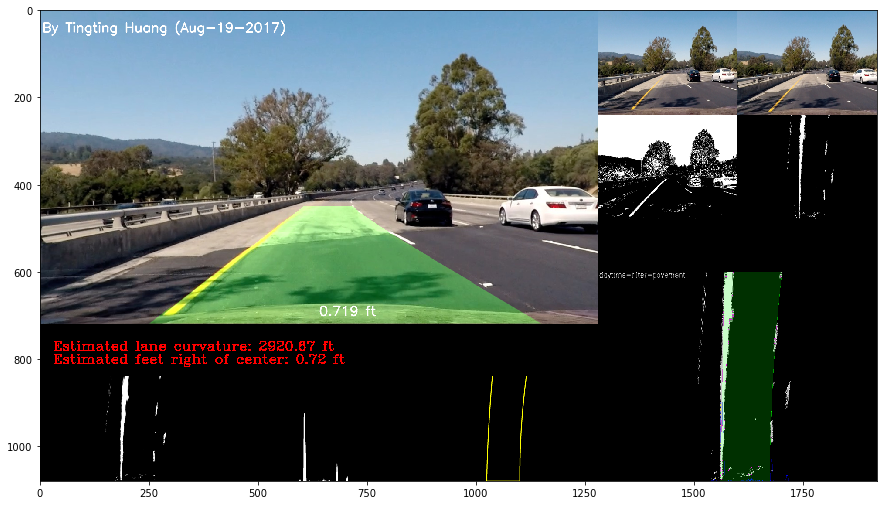

In [80]:
# interactively play around with the Lane() class to check the snapshots from the final output video

@interact
def lane_processing_test(images=fixed(images), i:(0,len(images)-1)=3):
    hist_count=6
    file,img=images[i]
    font = cv2.FONT_HERSHEY_SIMPLEX

    i_end = i + 1
    i_start = 0 if i_end < hist_count else i_end - hist_count

    #print(i_start,i_end)
    height, width = (720,1280)
    lane = Lane(height, width, mtx, dist)

    count = 0
    for _,image in images[i_start:i_end]:
        lane.image = image
        count += 1
    
#     return arr2img(lane.warped)
    return arr2img(lane.warped_decorated)
#     fig = plt.figure(figsize=(15,15))
#     plt.imshow(lane.warped_decorated)
#     fig.savefig('output_images/screen_output.png',bbox_inches='tight')
    
    result = lane.result_decorated    
    result = cv2.putText(result,'%4d' % i,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
    
#     result = warped_decorated
    
#     return arr2img(result)

In [76]:
# define a function to handle video frame by frame and output result to a new video

def do_project_video(file_name, output_name):
    height, width = (720,1280)
    lane = Lane(height, width, mtx, dist)
    count=0
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    def process_image(image):
        nonlocal count
        
        # process the lane image
        lane.image = image
        
#         result = lane.result_decorated
#         result = cv2.putText(result,'%4d' % count,(5,700), font, 1,(255,255,255),2,cv2.LINE_AA)
        
        result = lane.warped_decorated
        
        count +=1
        
        return result

    clip1 = VideoFileClip(file_name)
    lane_clip = clip1.fl_image(process_image) 
    %time lane_clip.write_videofile(output_name, audio=False)
    
#     return lane_clip

do_project_video("project_video.mp4","project_video_lane_output.mp4")
# do_project_video("challenge_video.mp4","challenge_video_lane_output.mp4")
# do_project_video("harder_challenge_video.mp4","harder_challenge_video_lane_output.mp4")

[MoviePy] >>>> Building video project_video_lane_output.mp4
[MoviePy] Writing video project_video_lane_output.mp4


100%|█████████▉| 1260/1261 [06:50<00:00,  2.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lane_output.mp4 

CPU times: user 7min 19s, sys: 1min 51s, total: 9min 11s
Wall time: 6min 52s
